# Titanic data
### getting started with kaggle

In [5]:
#load data
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from functon_scripts.col_names import col_names, namedict
from functon_scripts.SpecialImputers import ImputeAge, ImputeFare
from functon_scripts.CustomEstimators import CabinImputer, EmbarkedImputer, DoNothing, DropColumns, FareCat

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
labels = data['Survived']
data = data.drop('Survived', axis=1)
testdata = pd.read_csv(data_dir + 'test.csv')
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(data.shape)
print(data.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


**Pclass** : ticket class <br>
**SibSp** : # sibling or spouse aboard <br>
**Parch** : # parents or children aboard <br>
**Embark** : Port

In [9]:
# check the cabin data null values
data[(data.Pclass == 3) & (~data.Cabin.isnull())].shape

(12, 12)

In [7]:
# check which columns contain nan values
from functon_scripts.find_nan_cols import find_nan_cols

print(f'data:\t\t{find_nan_cols(data)} \ntestdata:\t{find_nan_cols(testdata)}')

data:		['Age', 'Cabin', 'Embarked'] 
testdata:	['Age', 'Fare', 'Cabin']


### Note:
We need to find ways to impute 'Age' and 'Fare' <br>
I dont think 'Embarked' is at all important <br>
'Cabin' can be converted into categorical (? maybe? need to check)

In [8]:
# if there is any Pclass that has non null values of cabin
print(data.Pclass[data.Cabin.isnull()].unique())

204

In [23]:
print(f'unique_cabin : {data.Cabin.unique().shape}\ntotal_Cabin_nan : {sum(data.Cabin.isnull())}')

unique_cabin : (148,)
total_Cabin_nan : 687


### Note2:
After imputing 'Age' and 'Fare', the list of explanatory variables becomes <br>
{id, Pclass, sex, age, sibsp, parch, fare, cabin}

using sibsp and parch can be tricky, maybe i need to form separate model for those, to provide probability of surviving, when you have extra family member

### Note3:
I think number of siblings or parents/children can defintely tell something about the age group of a person. The remaining variables that make a little to no sense are {Pclass, sex, Fare}

In [10]:
data.Ticket.to_csv(data_dir + 'tickets.csv')

# Create Pipelines

-- Drop Name, Ticket + add fam_n_frnd ;; Impute, categorize Cabin and Embarked <br>
-- One hot encode Cabin, Embarked, Sex, Pclass <br>
-- Create ordinal fare group {note that we can only group the data in training set}<br>
-- Impute ordinal fare {transformation will be tricky as it contains NaN values}<br>
-- impute Age <br>
====== thus cleaning is done
-- finally fit xgboost, svm and knn and use hard voting

In [6]:
cols = data.columns.drop(['Cabin', 'Embarked'])
imputer_1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 7], features=cols), cols),
    ('cabin_imp', CabinImputer(), ['Cabin']),
    ('Emb_imp', EmbarkedImputer(strategy='most_frequent'), ['Embarked'])
])

ohe_categories = [np.array([1, 2, 3], dtype=object),
                np.array(['female', 'male'], dtype=object),
                np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'], dtype=object),
                np.array(['C', 'Q', 'S'], dtype=object)]
                # had to fit a model and get the categories
ohe_cols = [0, 1, 6, 7]
nthn_cols = [2, 3, 4]
imputer_2 = ColumnTransformer([
    ('ohe', OneHotEncoder(categories=ohe_categories), ohe_cols),
    ('nthn', DoNothing(), nthn_cols),
    ('farecut', FareCat(), [5])
])

half_pipeline = Pipeline([
    ('imp1', imputer_1),
    ('imp2', imputer_2),
])

X = half_pipeline.fit_transform(data)
X = pd.DataFrame(X)
X.columns = imputer_2.get_feature_names()
X.head()

,ohe__x0_1,ohe__x0_2,ohe__x0_3,ohe__x1_female,ohe__x1_male,ohe__x2_A,ohe__x2_B,ohe__x2_C,ohe__x2_D,ohe__x2_E,...,ohe__x2_G,ohe__x2_T,ohe__x2_Z,ohe__x3_C,ohe__x3_Q,ohe__x3_S,nthn__Age,nthn__SibSp,nthn__Parch,farecut__Fare
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,22,1,0,1
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,38,1,0,3
2,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,26,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,35,1,0,3
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,35,0,0,1


### Pipeline: (conitinued)
Imputing Fare and Age

### Final Cleaning Pipeline

In [7]:
cleaning_pipeline = Pipeline([
    ('imp1', imputer_1),
    ('imp2', imputer_2),
    ('fare_imp', ImputeFare()),
    ('age_imp', ImputeAge()),
])

X = cleaning_pipeline.fit_transform(data)
X_test = cleaning_pipeline.transform(testdata)

X = pd.DataFrame(X.astype(float))
X.columns = col_names(features=namedict.keys())
sum(np.isnan(X_test.astype(float)))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Note9:
Finally cleaning is done. Need to create separate classifiers now and apply hard voting

In [28]:
#xgb model

param_grid = [
    {'n_estimators': np.arange(20, 90, step=10),
     'max_depth': [2, 3, 4],
     'max_leaf_nodes': [3, 4, 5, 6]
    },
]

grids_xgb = GridSearchCV(XGBClassifier(), param_grid, scoring="accuracy", return_train_score=True, cv=8)
grids_xgb.fit(X, labels)

joblib.dump(grids_xgb.best_estimator_, 'full_xgb_best.pkl')
grids_xgb.best_params_

{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 40}

0.830525390747599


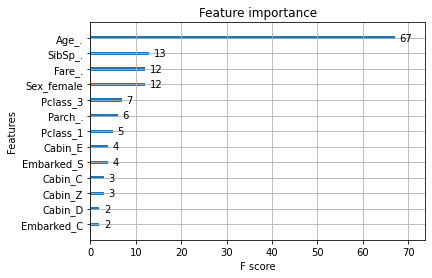

In [7]:
from xgboost import plot_importance

plot_importance(grids_xgb.best_estimator_)
print(grids_xgb.best_score_)

In [8]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels, grids_xgb.best_estimator_.predict(X))

0.8310804333237465

In [12]:
#logistic regression
param_grid = [
    {'C': np.arange(0.3, 0.8, step=0.05)}
]

grids_lgst = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), param_grid, scoring="accuracy", return_train_score=True, cv=5)
grids_lgst.fit(X, labels)

joblib.dump(grids_lgst.best_estimator_, 'full_logst_best.pkl')
grids_lgst.best_params_

{'C': 0.44999999999999996}

In [13]:
print(f'f1 = {grids_lgst.best_score_}')
print(f'auc = {roc_auc_score(labels, grids_lgst.best_estimator_.predict(X))}')

f1 = 0.7968551879982424
auc = 0.7860464001533889


In [14]:
# KNN
param_grid = [
    {'n_neighbors': np.arange(3, 10, step=1)}
]

grids_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", return_train_score=True, cv=5)
grids_knn.fit(X, labels)

joblib.dump(grids_knn.best_estimator_, 'full_knn_best.pkl')
grids_knn.best_params_

{'n_neighbors': 5}

In [131]:
print(f'f1 = {grids_knn.best_score_}')
print(f'auc = {roc_auc_score(labels, grids_knn.best_estimator_.predict(X))}')

f1 = 0.7248284728890595
auc = 0.8506375227686703


### Note10:
Hence three different classifier has been trained. We see that knn is performing better than logistic regression. We can still do pca and then apply all these algorithms. There is lot to improve like visualising the non linearity.. I think that's why logistic regression did not perform well.

## Hard Voting

{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estimators': 90} <br>
{'C': 0.44999999999999996} <br>
{'n_neighbors': 5}

In [21]:
from sklearn.ensemble import VotingClassifier

final_classifier = VotingClassifier([
    ('xgb', XGBClassifier(max_depth=2, max_leaf_nodes=3, n_estimators=50)),
    ('lgst', LogisticRegression(C=0.45)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
], voting='hard')

full_pipeline = Pipeline([
    ('clean', cleaning_pipeline),
    ('estimate', final_classifier)
])

model_1 = full_pipeline.fit(data, labels)
model_1.predict(testdata)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [22]:
scores = cross_val_score(model_1, data, labels, cv=7, scoring='accuracy')
scores

array([0.8125    , 0.8203125 , 0.8503937 , 0.81102362, 0.82677165,
       0.81889764, 0.86614173])

In [23]:
submit = testdata.PassengerId.to_frame()
submit['Survived'] = pd.Series(model_1.predict(testdata), dtype=object)

In [24]:
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [25]:
submit.to_csv(data_dir + 'submission_accuracy.csv', index=False)

In [203]:
sum(submit.Survived.isnull())

1